<h1>Содержание проекта<span class="tocSkip"></span></h1>

1  Загрузка, изучение, обработка данных

2  Подготовка данных для обучения

    2.1  Обработка данных

    2.2  Создание датасетов

3  Построение разных моделей

    3.1  DecisionTreeClassifier
    3.2  AdaBoostClassifier
    3.3  LogisticRegression
    3.4  RandomForestClassifier
    3.5  Выводы и выбор лучшей модели

4  Тестирование лучшей модели

5  Общий вывод

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других.

В вашем распоряжении набор данных с разметкой о токсичности правок.


# Цели и задачи проекта

**Цель проекта:** Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. Обучите модель классифицировать комментарии на позитивные и негативные. 

**Условия задачи:**
- Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта:**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных:**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.



**План выполнения работ:**

- 1. Загрузить, изучить, при необходимости обработать данные
- 2. Подготовить данные для обучения
- 3. Построить разные модели:
    - DecisionTreeClassifier
    - LogisticRegression
    - RandomForestClassifier
- 4. Протестировать лучшую модель
- 5. Сделать выводы


## Загрузка, изучение, обработка данных

In [ ]:
#импорты настройки функции
import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(16,6)})
sns.set_palette('dark:#5A9_r')

from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.utils import shuffle

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords as nltk_stopwords
stopwords_en = set(nltk_stopwords.words('english'))
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

import re
    
# для оценки времени
from tqdm.auto import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()
import time

# остальное
import warnings
warnings.filterwarnings('ignore')

In [3]:
# функция очистки лишних символов и приведения к нижнему регистру
def clear_text(text):
    text = text.replace('\n',' ')
    text = re.sub(r'[^\'a-zA-Z ]', ' ', text.lower())
    return " ".join(text.split())

# функция токенизации (результат без пустых слов)
def tokenize(text):
    tokenized = re.split(' ', text)
    return [w for w in tokenized if w!='']

# функция лемматизации с get_wordnet_pos
def lemmatize(text):
    #lems = []
    #for w in text:
    #    lems.append(lemmatizer.lemmatize(w))
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]

# кэш для частей слов
WORD_POS_CACHE = {}

# функция чати речи для лемматизации
def get_wordnet_pos(word):
    if word in WORD_POS_CACHE:
        return WORD_POS_CACHE[word]
    
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    result = tag_dict.get(tag, wordnet.NOUN)
    WORD_POS_CACHE[word] = result
    return result

# функция очистки стоп-слов
def clear_stopwords(text):
    result_text = []
    for w in text:
        if w not in stopwords_en:
            result_text.append(w)
    return " ".join(result_text)

## рисуем AUC-ROC
def do_roc_curve(taget,predicted,model_ident,f1,auc_roc):
    fpr, tpr, thresholds = roc_curve(taget, predicted) 
    plt.figure();
    plt.plot([0, 1], [0, 1], linestyle='--', color="#777", linewidth=.9)
    plt.plot(fpr, tpr, linestyle='-', color="#8c75b6", linewidth=3)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")    
    plt.title('ROC-кривая '+model_ident+' | F1 '+str(round(f1,4))\
            +' | AUC-ROC '+str(round(auc_roc,4)))
    plt.show();
    return True

**Загрузим и посмотрим на данные**

In [4]:
# загружаем данные
data = pd.read_csv("/datasets/toxic_comments.csv",
                   index_col=0 # чтобы не было столбца Unnamed: 0 при чтении файла
                  )

In [5]:
display(data.head())
display(data.tail())
display(data.info())
print('-'*50)
print('Проверка разметки токсичных комментариев:')
display(data.query('toxic == 1').sample(8))

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


,text,toxic
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0
159450,"""\nAnd ... I really don't think you understand...",0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

--------------------------------------------------
Проверка разметки токсичных комментариев:


,text,toxic
7248,It would if you translate it instead of postin...,1
97469,"""\nI'll respond to you after the block one of ...",1
131381,God gives his beloved SLEEP. ARE YOU HERE TO D...,1
33856,Fuck you you stupid and gay bastard who thinls...,1
141907,"Well, you might not be welcoming me if you kne...",1
21673,all wikipedians are nob heads who should resig...,1
124083,Hello \n\nHey asshole! I kill you. Filthy Musl...,1
135047,"This is internet so isn't a personal attack, I...",1


**Имеем следующий набор данных:**

**Признаки**  
  - `text` — нужно использовать для обучения
  - ~`Unnamed: 0` — какой-то внутренний id судя по всему, нам не нужен~
    
**Целевой признак**  
  - `toxic` — токсичность (да-нет) комментария
  
Судя по данным - помечены действительно токсичные комментарии.

In [6]:
# data.drop(['Unnamed: 0'], axis=1, inplace=True)
# data.head()

Посмотрим на дубликаты

In [7]:
print()
print('Полных дубликатов:', sum(data.duplicated()))


Полных дубликатов: 0


Проверим пропуски

In [8]:
data.isna().sum()

text     0
toxic    0
dtype: int64

На всякий случай проверим что в целевом признаке действительно только два значения.

Уникальные значений в toxic: [0 1]


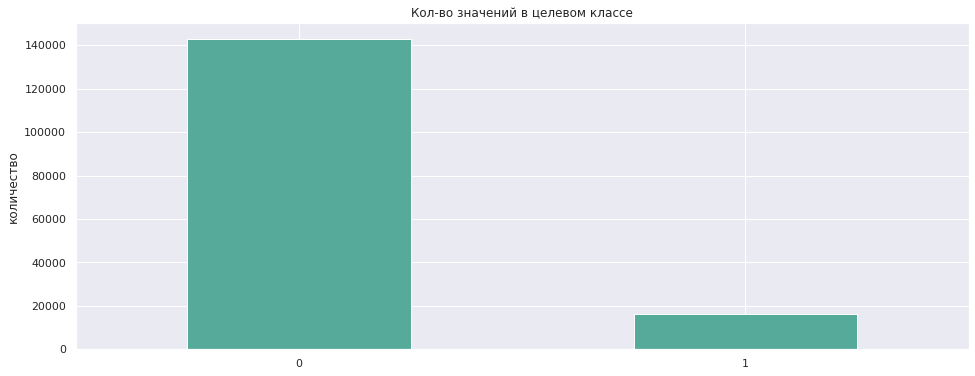

In [9]:
toxic_unique_count = data['toxic'].unique()
print('Уникальные значений в toxic:',toxic_unique_count)
# data.hist(bins=len(toxic_unique_count));
data['toxic'].value_counts().sort_index().plot(kind='bar', rot=0, ylabel='количество', title='Кол-во значений в целевом классе')
plt.show();

1. Да, в целевом признаке только 0/1.

2. Наблюдаем явный дисбаланс в классе, это может испортить качество моделей, учтем это.

## Подготовка данных для обучения

### Обработка данных

`Токенизация (англ. tokenization)` — разбиение текста на токены: отдельные фразы, слова, символы.

`Лемматизация (англ. lemmatization)` — приведение слова к начальной форме — лемме.

Приступим к обработке текста.

In [11]:
# сохраним оригинальный текст в другом столбце на всякий случай
data['origin'] = data['text'].copy()

In [12]:
%%time
# почистим текст от лишних символов, переносов строк
data['text'] = data['origin'].progress_apply(clear_text)
data.head()

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 2.54 s, sys: 99.4 ms, total: 2.64 s
Wall time: 2.78 s


,text,toxic,origin
0,explanation why the edits made under my userna...,0,Explanation\nWhy the edits made under my usern...
1,d'aww he matches this background colour i'm se...,0,D'aww! He matches this background colour I'm s...
2,hey man i'm really not trying to edit war it's...,0,"Hey man, I'm really not trying to edit war. It..."
3,more i can't make any real suggestions on impr...,0,"""\nMore\nI can't make any real suggestions on ..."
4,you sir are my hero any chance you remember wh...,0,"You, sir, are my hero. Any chance you remember..."


In [13]:
%%time
# токенизируем
data['text'] = data['text'].progress_apply(tokenize)
data.head()

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 2.61 s, sys: 417 ms, total: 3.03 s
Wall time: 3.17 s


,text,toxic,origin
0,"[explanation, why, the, edits, made, under, my...",0,Explanation\nWhy the edits made under my usern...
1,"[d'aww, he, matches, this, background, colour,...",0,D'aww! He matches this background colour I'm s...
2,"[hey, man, i'm, really, not, trying, to, edit,...",0,"Hey man, I'm really not trying to edit war. It..."
3,"[more, i, can't, make, any, real, suggestions,...",0,"""\nMore\nI can't make any real suggestions on ..."
4,"[you, sir, are, my, hero, any, chance, you, re...",0,"You, sir, are my hero. Any chance you remember..."


In [16]:
%%time
# лемматизируем
lemmatizer = WordNetLemmatizer()
data['text'] = data['text'].progress_apply(lemmatize)
data.head()

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 1min 10s, sys: 2.95 s, total: 1min 13s
Wall time: 1min 15s


,text,toxic,origin
0,"[explanation, why, the, edits, make, under, my...",0,Explanation\nWhy the edits made under my usern...
1,"[d'aww, he, match, this, background, colour, i...",0,D'aww! He matches this background colour I'm s...
2,"[hey, man, i'm, really, not, try, to, edit, wa...",0,"Hey man, I'm really not trying to edit war. It..."
3,"[more, i, can't, make, any, real, suggestion, ...",0,"""\nMore\nI can't make any real suggestions on ..."
4,"[you, sir, be, my, hero, any, chance, you, rem...",0,"You, sir, are my hero. Any chance you remember..."


In [17]:
%%time
# теперь удалим стоп-слова
data['text'] = data['text'].progress_apply(clear_stopwords)
data.head()

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 1.43 s, sys: 19.8 ms, total: 1.45 s
Wall time: 1.5 s


,text,toxic,origin
0,explanation edits make username hardcore metal...,0,Explanation\nWhy the edits made under my usern...
1,d'aww match background colour i'm seemingly st...,0,D'aww! He matches this background colour I'm s...
2,hey man i'm really try edit war guy constantly...,0,"Hey man, I'm really not trying to edit war. It..."
3,can't make real suggestion improvement wonder ...,0,"""\nMore\nI can't make any real suggestions on ..."
4,sir hero chance remember page that's,0,"You, sir, are my hero. Any chance you remember..."


**Вывод: Данные подготовили для обучения.**

- почистили текст от лишних символов, переносов строк
- токенизировали
- лемматизировали
- удалили стоп-слова

### Создание датасетов

In [18]:
# создадим признаки и класс
features = data['text']#.astype('U')
target = data['toxic']

# разобьем на выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345, stratify=target)

# и сделаем валидационные выборки
features_train, features_val, target_train, target_val = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345, stratify=target_train
)

In [19]:
# Создаем счетчик TF-IDF
tf_idf = TfidfVectorizer(stop_words=list(stopwords_en))

In [20]:
%%time
# Закодируем
features_train = tf_idf.fit_transform(features_train)
features_val = tf_idf.transform(features_val)
features_test = tf_idf.transform(features_test)

CPU times: user 5.12 s, sys: 40.2 ms, total: 5.16 s
Wall time: 5.17 s


In [21]:
print('features_train')
display(features_train.shape)
print()
print('features_val')
display(features_val.shape)
print()
print('features_test')
display(features_test.shape)

features_train


(89601, 108146)


features_val


(29868, 108146)


features_test


(39823, 108146)

**Вывод: Подготовили датасеты для построения моделей.**
- обозначили признаки и класс
- разбили на выборки (обучающую, валидационную и тестовую)
- закодировали посредством TF-IDF

## Построение разных моделей

In [22]:
all_results = {}

Напишем циклы, в которых сможем перебрать гиперпараметры и построить модели.

### DecisionTreeClassifier

  0%|          | 0/6 [00:00<?, ?it/s]


DecisionTreeClassifier

Параметры: class_weight=None, max_depth=64
F1 = 0.7115063924402445

Параметры: class_weight=balanced, max_depth=64
F1 = 0.6031651239175874

Параметры: class_weight=None, max_depth=114
F1 = 0.7148694261858235

Параметры: class_weight=balanced, max_depth=114
F1 = 0.6281895504252735

Параметры: class_weight=None, max_depth=128
F1 = 0.7157485875706214

Параметры: class_weight=balanced, max_depth=128
F1 = 0.6353190202600544



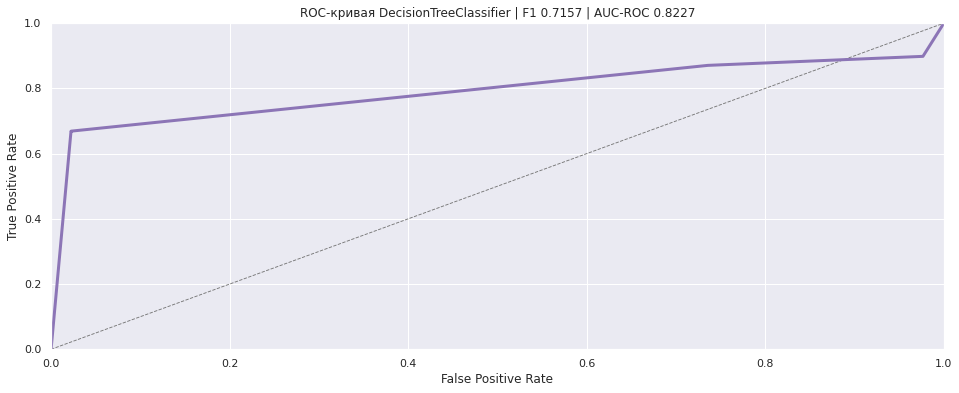


Лучшая модель: F1 0.7157485875706214
Параметры: {'max_depth': 128, 'class_weight': None}
Скорость обучения: 49.16742992401123
Скорость предсказания: 0.016824722290039062

DecisionTreeClassifier показала макс F1 0.7157


In [23]:
model_name = 'DecisionTreeClassifier'

# параметр для учета дисбаланса в классе
param_class_weight = [None,'balanced']
p_max_depth = [64,114,128]

pbar = tqdm(total=len(p_max_depth)*len(param_class_weight))

print()
print(f"{model_name}")

max_f1 = 0
for max_depth in p_max_depth:
    for class_weight in param_class_weight:

        model = DecisionTreeClassifier(
            max_depth=max_depth,
            class_weight=class_weight,
            random_state=12345
        )

        start_learn = time.time()
        model.fit(features_train, target_train)
        end_learn = time.time()

        start_predict = time.time()
        predictions_val = model.predict(features_val)
        end_predict = time.time()

        f1 = f1_score(target_val.values, predictions_val)

        if f1>max_f1:
            max_f1=f1
            auc_roc = roc_auc_score(target_val,predictions_val)
            probabilities = model.predict_proba(features_val)
            result = {
                'params':{
                    'max_depth':max_depth,
                    'class_weight':class_weight
                },
                'result':{
                    'f1':f1,
                    'time_learn':(end_learn - start_learn),
                    'time_predict':(end_predict - start_predict),
                    'auc_roc':auc_roc,
                    'predicted':predictions_val,
                    'probabilities':probabilities[:,1]
                },
                'model': model
            }
        print()
        print(f'Параметры: class_weight={class_weight}, max_depth={max_depth}')
        print('F1 =',f1)
        pbar.update()
pbar.close()

all_results[model_name] = result

print()
# выводим график 
do_roc_curve(target_val,all_results[model_name]['result']['probabilities'],
             model_name,result['result']['f1'],result['result']['auc_roc']);
print()

print(f"Лучшая модель: F1 {result['result']['f1']}")
print(f"Параметры: {result['params']}")
print(f"Скорость обучения: {result['result']['time_learn']}")
print(f"Скорость предсказания: {result['result']['time_predict']}")
print()
print(f"{model_name} показала макс F1 {round(result['result']['f1'],4)}")

*Отметим, что в дереве решений class_weight=balanced даёт худшие результаты, чем class_weight=None.*

### AdaBoostClassifier

  0%|          | 0/1 [00:00<?, ?it/s]


AdaBoostClassifier

Параметры: DTC_tree_max_depth: 1, n_estimators=900
F1 = 0.7594390507011867



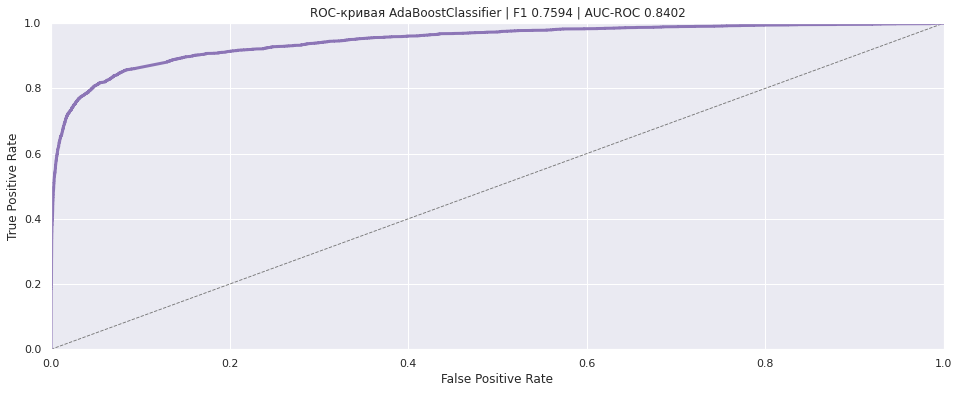


Лучшая модель: F1 0.7594390507011867
Параметры: {'n_estimators': 900, 'DTC_tree_max_depth': 1}
Скорость обучения: 414.8768427371979
Скорость предсказания: 6.59082555770874

AdaBoostClassifier показала макс F1 0.7594


In [24]:
model_name = 'AdaBoostClassifier'

#изначальный вариант перебора
#p_n_estimators = [300,600,900]
#DTC_tree_max_depths = [1,3]

p_n_estimators = [900]
DTC_tree_max_depths = [1]

pbar = tqdm(total=len(p_n_estimators)*len(DTC_tree_max_depths))

print()
print(f"{model_name}")

max_f1 = 0
for DTC_tree_max_depth in DTC_tree_max_depths:
    for n_estimators in p_n_estimators:
        
        model = AdaBoostClassifier(
            n_estimators=n_estimators,
            estimator=DecisionTreeClassifier(
                max_depth=DTC_tree_max_depth, random_state=12345),
            random_state=12345
        )

        start_learn = time.time()
        model.fit(features_train, target_train)
        end_learn = time.time()

        start_predict = time.time()
        predictions_val = model.predict(features_val)
        end_predict = time.time()

        f1 = f1_score(target_val.values, predictions_val)

        if f1>max_f1:
            max_f1=f1
            auc_roc = roc_auc_score(target_val,predictions_val)
            probabilities = model.predict_proba(features_val)
            result = {
                'params':{
                    'n_estimators':n_estimators,
                    'DTC_tree_max_depth':DTC_tree_max_depth
                },
                'result':{
                    'f1':f1,
                    'time_learn':(end_learn - start_learn),
                    'time_predict':(end_predict - start_predict),
                    'auc_roc':auc_roc,
                    'predicted':predictions_val,
                    'probabilities':probabilities[:,1]
                },
                'model': model
            }
        print()
        print(f'Параметры: DTC_tree_max_depth: {DTC_tree_max_depth}, n_estimators={n_estimators}')
        print('F1 =',f1)
        pbar.update()
pbar.close()

all_results[model_name] = result

print()
# выводим график 
do_roc_curve(target_val,all_results[model_name]['result']['probabilities'],
             model_name,result['result']['f1'],result['result']['auc_roc']);
print()
print(f"Лучшая модель: F1 {result['result']['f1']}")
print(f"Параметры: {result['params']}")
print(f"Скорость обучения: {result['result']['time_learn']}")
print(f"Скорость предсказания: {result['result']['time_predict']}")
print()
print(f"{model_name} показала макс F1 {round(result['result']['f1'],4)}")

### LogisticRegression


LogisticRegression


  0%|          | 0/6 [00:00<?, ?it/s]


Параметры: class_weight=None, C=1
F1 = 0.7214040750453904

Параметры: class_weight=None, C=3
F1 = 0.7510078709925129

Параметры: class_weight=None, C=5
F1 = 0.7560606060606061

Параметры: class_weight=balanced, C=1
F1 = 0.740503565710959

Параметры: class_weight=balanced, C=3
F1 = 0.7510523150932049

Параметры: class_weight=balanced, C=5
F1 = 0.7511808624104831



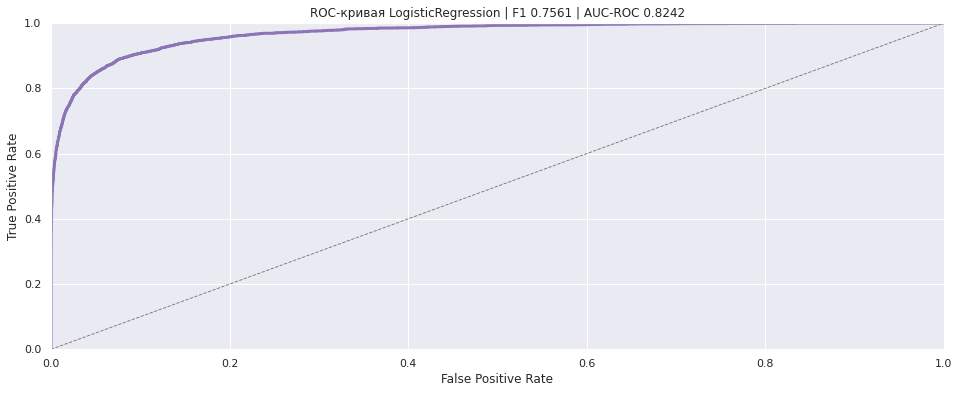


Лучшая модель: F1 0.7560606060606061
Параметры: {'class_weight': None, 'C': 5}
Скорость обучения: 37.48591947555542
Скорость предсказания: 0.0030820369720458984

LogisticRegression показала макс F1 0.7561


In [25]:
model_name = 'LogisticRegression'
# параметры для тестирования

print()
print(f"{model_name}")

# параметр для учета дисбаланса в классе
param_class_weight = [None,'balanced']
#C (C Regularization Parameter) – это параметр штрафования или неверной классификации.
#За каждую ошибку модель можно штрафовать ( penalty ), и это увеличит эффективность.
params_c = [1,3,5]

pbar = tqdm(total=len(params_c)*len(param_class_weight))

max_f1 = 0
for class_weight in param_class_weight:
    for param_c in params_c:

        model = LogisticRegression(
            random_state=12345,
            class_weight=class_weight,
            C=param_c)

        start_learn = time.time()
        model.fit(features_train, target_train)
        end_learn = time.time()

        start_predict = time.time()
        predictions_val = model.predict(features_val)
        end_predict = time.time()

        f1 = f1_score(target_val.values, predictions_val)

        if f1>max_f1:
            max_f1=f1
            auc_roc = roc_auc_score(target_val,predictions_val)
            probabilities = model.predict_proba(features_val)
            result = {
                'params':{
                    'class_weight':class_weight,
                    'C':param_c
                },
                'result':{
                    'f1':f1,
                    'time_learn':(end_learn - start_learn),
                    'time_predict':(end_predict - start_predict),
                    'auc_roc':auc_roc,
                    'predicted':predictions_val,
                    'probabilities':probabilities[:,1]
                },
                'model': model
            }
        print()
        print(f'Параметры: class_weight={class_weight}, C={param_c}')
        print('F1 =',f1)

        pbar.update()
pbar.close()

all_results[model_name] = result

print()
# выводим график 
do_roc_curve(target_val,all_results[model_name]['result']['probabilities'],
             model_name,result['result']['f1'],result['result']['auc_roc']);
print()
print(f"Лучшая модель: F1 {result['result']['f1']}")
print(f"Параметры: {result['params']}")
print(f"Скорость обучения: {result['result']['time_learn']}")
print(f"Скорость предсказания: {result['result']['time_predict']}")
print()
print(f"{model_name} показала макс F1 {round(result['result']['f1'],4)}")

### RandomForestClassifier

  0%|          | 0/4 [00:00<?, ?it/s]


RandomForestClassifier

Параметры: class_weight=None, max_depth=256, n_estimators=20
F1 = 0.5686635944700461

Параметры: class_weight=None, max_depth=256, n_estimators=100
F1 = 0.6064047240517828

Параметры: class_weight=balanced, max_depth=256, n_estimators=20
F1 = 0.5796943231441049

Параметры: class_weight=balanced, max_depth=256, n_estimators=100
F1 = 0.598439821693908



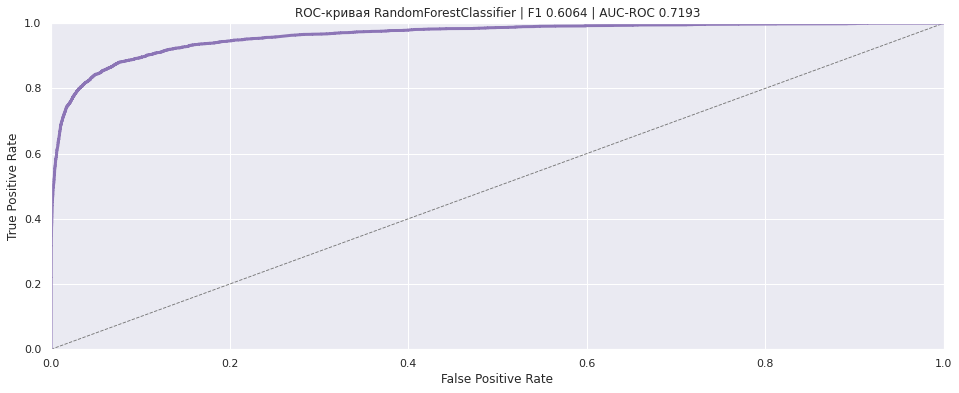


Лучшая модель: F1 0.6064047240517828
Параметры: {'max_depth': 256, 'n_estimators': 100, 'class_weight': None}
Скорость обучения: 232.37261843681335
Скорость предсказания: 2.4138023853302

RandomForestClassifier показала макс F1 0.6064


In [26]:
model_name = 'RandomForestClassifier'

# параметр для учета дисбаланса в классе
param_class_weight = [None,'balanced']
p_max_depth = [256]
p_n_estimators = [20,100]

pbar = tqdm(total=len(p_max_depth)*len(param_class_weight)*len(p_n_estimators))

print()
print(f"{model_name}")

max_f1 = 0
for class_weight in param_class_weight:
    for max_depth in p_max_depth:
        for n_estimators in p_n_estimators:

            model = RandomForestClassifier(
                max_depth=max_depth,
                class_weight=class_weight,
                n_estimators=n_estimators,
                random_state=12345
            )

            start_learn = time.time()
            model.fit(features_train, target_train)
            end_learn = time.time()

            start_predict = time.time()
            predictions_val = model.predict(features_val)
            end_predict = time.time()

            f1 = f1_score(target_val.values, predictions_val)

            if f1>max_f1:
                max_f1=f1
                auc_roc = roc_auc_score(target_val,predictions_val)
                probabilities = model.predict_proba(features_val)
                result = {
                    'params':{
                        'max_depth':max_depth,
                        'n_estimators':n_estimators,
                        'class_weight':class_weight
                    },
                    'result':{
                        'f1':f1,
                        'time_learn':(end_learn - start_learn),
                        'time_predict':(end_predict - start_predict),
                        'auc_roc':auc_roc,
                        'predicted':predictions_val,
                        'probabilities':probabilities[:,1]
                    },
                    'model': model
                }
            print()
            print(f'Параметры: class_weight={class_weight}, max_depth={max_depth}, n_estimators={n_estimators}')
            print('F1 =',f1)
            pbar.update()
pbar.close()

all_results[model_name] = result

print()
# выводим график 
do_roc_curve(target_val,all_results[model_name]['result']['probabilities'],
             model_name,result['result']['f1'],result['result']['auc_roc']);
print()
print(f"Лучшая модель: F1 {result['result']['f1']}")
print(f"Параметры: {result['params']}")
print(f"Скорость обучения: {result['result']['time_learn']}")
print(f"Скорость предсказания: {result['result']['time_predict']}")
print()
print(f"{model_name} показала макс F1 {round(result['result']['f1'],4)}")

### Выводы и выбор лучшей модели

**Посмотрим на сводную таблицу результатов по всем моделям**

In [27]:
df_data = []
for model, model_result in all_results.items():
    df_data.append([
        model,
        round(model_result['result']['f1'],4),
        str(round(model_result['result']['time_learn'],2))+' сек.',
        str(round(model_result['result']['time_predict'],2))+' сек.',
        str(model_result['params'])
    ])
df = pd.DataFrame(df_data, columns=['Модель', 'F1 (valid)',
                                    'Скорость обучения', 'Скорость предсказания', 'Параметры'])
df = df.sort_values('F1 (valid)',ascending=False)
df.style.hide_index()

Модель,F1 (valid),Скорость обучения,Скорость предсказания,Параметры
AdaBoostClassifier,0.759400,414.88 сек.,6.59 сек.,"{'n_estimators': 900, 'DTC_tree_max_depth': 1}"
LogisticRegression,0.756100,37.49 сек.,0.0 сек.,"{'class_weight': None, 'C': 5}"
DecisionTreeClassifier,0.715700,49.17 сек.,0.02 сек.,"{'max_depth': 128, 'class_weight': None}"
RandomForestClassifier,0.606400,232.37 сек.,2.41 сек.,"{'max_depth': 256, 'n_estimators': 100, 'class_weight': None}"


**Как мы видим по предсказанию на валидационной выборке:**

- Модель LogisticRegression смогла показать результат F1=0.7545 (>0.75).
    - она быстро обучается и прогнозирует данные
    
    Параметры: `{'class_weight': None, 'C': 5}`
    
    Скорость обучения: 39.38 сек. , предсказания: 0.003 сек.
   
   
- Модель AdaBoostClassifier смогла показать результат F1=0.7594 (>0.75 и самый высокий показатель).
    - стоит учесть, что эта модель долго обучается
    
    Параметры: `{'n_estimators': 900, 'DTC_tree_max_depth': 1}`
    
    Скорость обучения: 414.9 сек. , предсказания: 6.59 сек.
    
    
- Две другие модели не достигли минимальной планки F1 в 0.75

    - DecisionTreeClassifier показала макс = F1 0.7157
    
        Параметры: `{'max_depth': 128, 'class_weight': None}`
        
        Скорость обучения: 49.17, предсказания: 0.017 сек.
        
    - RandomForestClassifier показала макс = F1 0.6089
    
        Параметры: `{'max_depth': 256, 'n_estimators': 100, 'class_weight': None}`

        Скорость обучения: 232.37 сек., предсказания: 2.41 сек.
     
     
- Сделана сводная таблица результатов обучения моделей
- Выбрана лучшая модель:

**Лучшая модель:**
- AdaBoostClassifier	

    F1 (valid) = 0.7594
    
    Скорость обучения	414.9 сек.
    
    Скорость предсказания	6.59 сек.
    
    Параметры `{'n_estimators': 900, 'DTC_tree_max_depth': 1}`
    
*Заметим, что эта модель обучается значительно дольше остальных, но немного лучше по F1-мере. Соответственно, если будет важна скорость обучения, то лучше выбрать LogisticRegression, которая также показала >0.75 на валидационной выборке.* 

## Тестирование лучшей модели

**Протестируем лучшую модель на тестовой выборке.**

Значение метрики F1 на тестовой выборке должно быть не менее 0.75 по условиям задания.

In [29]:
model_name = 'AdaBoostClassifier'

## сразу и таблицу создадим, и предсказания сделаем
df_data = []

top_model = all_results[model_name]['model']

# делаем предсказание сохраненной лучшей моделью по тестовым данным
start_predict = time.time()
predictions_test = top_model.predict(features_test)    
end_predict = time.time()

# считаем f1 test
f1_test = f1_score(target_test.values, predictions_test)

df_data.append([
    model_name,
    round(f1_test,3),
    round(all_results[model_name]['result']['f1'],3),
    str(round(all_results[model_name]['result']['time_learn'],3))+' сек.',
    str(round((end_predict-start_predict),3))+' сек.',
    str(all_results[model_name]['params'])
])
df = pd.DataFrame(df_data, columns=['Модель', 'F1 TEST', 'F1 valid',
                                    'Скорость обучения', 'Скорость предск. TEST', 'Параметры'])

display(df.style.hide_index())
print(f'Как мы видим, модель {model_name} показывает F1={round(f1_test,3)}\
\nна тестовой выборке, что соответствует условиям задачи (F1>=0.75).')

Модель,F1 TEST,F1 valid,Скорость обучения,Скорость предск. TEST,Параметры
AdaBoostClassifier,0.755000,0.759000,414.877 сек.,9.103 сек.,"{'n_estimators': 900, 'DTC_tree_max_depth': 1}"


Как мы видим, модель AdaBoostClassifier показывает F1=0.755
на тестовой выборке, что соответствует условиям задачи (F1>=0.75).


**Задача решена.**

## Общий вывод

Перед нами стояли следующие цели и задачи:

**Цель проекта:** Обучить модель классифицировать комментарии на позитивные и негативные.

**Условия задачи:** Значение метрики *F1* на тестовой выборке должно быть не менее 0.75.

**Мы выполнили работы:**

1. Загрузили, изучили и обработали данные
    - Загрузили и изучили общую информацию о данных. Обнаружили дисбаланс в классе.
    - Проверили разметку токсичных комментариев, отсутствие дубликатов и отсутствующих данных.


2. Подготовили данные для обучения

    2.1. Обработали данные
        - почистили текст от лишних символов, переносов строк
        - токенизировали
        - лемматизировали
        - удалили стоп-слова (english)
        
    2.2. Подготовили датасеты для построения моделей.
        - обозначили признаки и класс
        - разбили на выборки (обучающую, валидационную и тестовую)
        - закодировали посредством TF-IDF
    

3. Построили разные модели и протестировали на валидационной выборке:

    - Сделали сводную таблицу результатов обучения моделей
    - Оценили качество моделей и выбрали лучшую:

    3.1  DecisionTreeClassifier
    
        - показала макс F1 0.7157, результат не соответствует мин. F1 >=0.75
    
    3.2  AdaBoostClassifier (лучшая)

        - смогла показать результат F1=0.759 (>0.75)
        - долго обучается, но это не противоречит условиям задачи
    
    3.3  LogisticRegression
    
        - смогла показать результат F1=0.755 (>0.75)
        - в случае, если скорость обучения важна - лучше выбрать её
    
    3.4  RandomForestClassifier
    
        - показала макс F1=0.606, результат не соответствует мин. F1 >=0.75
    
    3.5. Определили лучшую модель:
        - AdaBoostClassifier	
            F1 (valid) = 0.759
            Скорость обучения	414.88 сек.		
            Скорость предсказания	6.59 сек.
            Параметры `{'n_estimators': 900, 'DTC_tree_max_depth': 1}`
    
    
4. Проверили данные на тестовой выборке и сделали выводы.

   Модель AdaBoostClassifier показывает F1=0.755 (>0.75 по условиям задачи) на тестовой выборке.

**Поставленные задачи выполнены.**